# Occupancy Predictor

This notebook looks at the results of the BRAILS occupancy module against data that was scraped from the
[Miami-Dade Property Search](https://www.miamidade.gov/Apps/PA/propertysearch/) web application.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use("typewriter")

from scripts.plotting import plot_confusion_matrix
import sklearn.metrics
import pandas as pd

## Configuration

In [2]:
WRITE = True
MODEL = "occupancy-2"
SEP = "\t" # write out data in TSV format for easy command line processing.
outdir = Path("./out/")
CONF_THRESH = 0.9
label_keys = ["RES1", "COM", "RES3"]
label_file = "labels/scrape-uniq.tsv"
pred_file = "models/occupancy_preds.csv"
omissions = [
    "labels/image_errors.txt",
    "labels/street_filter2.txt",
    "labels/street_filter.txt",
    "labels/street_filter-blur.txt"
]

The `occupancies` dictionary maps classifications used by BRAILS to those found in the data set.

In [3]:
occupancies = {
    "RES1": [
        "IMPR AGRI : RESIDENTIAL - SINGLE FAMILY",
        "RESIDENTIAL - SINGLE FAMILY : 1 UNIT",
        "RESIDENTIAL - SINGLE FAMILY : ADDITIONAL LIVING QUARTERS",
        "RESIDENTIAL - SINGLE FAMILY : CLUSTER HOME",
        "RESIDENTIAL - SINGLE FAMILY : RESIDENTIAL - TOTAL VALUE",
        "VACANT RESIDENTIAL : EXTRA FEA OTHER THAN PARKING",
        "VACANT RESIDENTIAL : VACANT LAND",
        "MULTIFAMILY 2-9 UNITS : 2 LIVING UNITS",
        
        "MULTIFAMILY 10 UNITS PLUS : MULTIFAMILY 3 OR MORE UNITS",
    ],
    "RES3": [
        "MULTIFAMILY 2-9 UNITS : MULTIFAMILY 3 OR MORE UNITS",
        "RESIDENTIAL - TOTAL VALUE : CONDOMINIUM - RESIDENTIAL",
        "RESIDENTIAL - TOTAL VALUE : TOWNHOUSE",
    ],
    "COM": [
        "BOARD OF PUBLIC INSTRUCTION : BOARD OF PUBLIC INSTRUCTION",
        "HOTEL OR MOTEL : MOTEL",
        "RELIGIOUS - EXEMPT : RELIGIOUS",
        "RESTAURANT OR CAFETERIA : RETAIL OUTLET",
        "SERVICE STATION : RETAIL OUTLET",
        "SERVICE STATION : SERVICE STATION - AUTOMOTIVE",
        "STORE : RETAIL OUTLET",
        "TOURIST ATTRACTION/EXHIBIT : ENTERTAINMENT",
        "UTILITY : UTILITY",
        "MUNICIPAL : MUNICIPAL",
        "OFFICE BUILDING - MULTISTORY : OFFICE BUILDING",
        "OFFICE BUILDING - ONE STORY : OFFICE BUILDING",
        "PARKING LOT/MOBILE HOME PARK : PARKING LOT",
        "PROFESSIONAL SERVICE BLDG : OFFICE BUILDING",
        "REFERENCE FOLIO",
        "REPAIR SHOP/NON AUTOMOTIVE : REPAIRS - NON AUTOMOTIVE",

        "AUTOMOTIVE OR MARINE : AUTOMOTIVE OR MARINE",
        "COUNTY : DADE COUNTY",
        "EDUCATIONAL/SCIENTIFIC - EX : EDUCATIONAL - PRIVATE",
        "ENCLOSED RECEATIONAL ARENA : ENTERTAINMENT",
        "FINANCIAL INSTITUTION : OFFICE BUILDING",
        "HOME FOR THE AGED : HEALTH CARE",
    ]
}
inv_occ = {c: k for k,v in occupancies.items() for c in v}

## Data processing

In [4]:
preds = pd.read_csv(pred_file)
preds["image"] = preds["image"].apply(lambda x: str(Path(x).name))
preds = preds.set_index("image")

In [5]:
labels = pd.read_csv(
    label_file,
    sep="\t",
    names=["coords","address","folio","occupancy","floors","year"],index_col=False,
    header=None
)

In [6]:
labels["image"] = labels["coords"].apply(lambda c: f"StreetViewx{c.split(',')[1]}x{c.split(',')[0]}.png")

In [7]:
labels["label"] = labels["occupancy"].apply(lambda x: inv_occ[x])
labels = labels.set_index("image").drop(columns=["address","folio","coords"])
labels = labels.join(preds)
labels

,occupancy,floors,year,label,prediction,probability
image,,,,,,
StreetViewx-80.450852x25.441624.png,RESIDENTIAL - SINGLE FAMILY : 1 UNIT,1,1998,RES1,RES3,0.000000
StreetViewx-80.456833x25.442976.png,RESIDENTIAL - TOTAL VALUE : TOWNHOUSE,2,0,RES3,RES3,1.000000
StreetViewx-80.447654x25.443812.png,RESIDENTIAL - TOTAL VALUE : CONDOMINIUM - RESI...,1,0,RES3,RES3,0.000000
StreetViewx-80.447292x25.444620.png,RESIDENTIAL - TOTAL VALUE : CONDOMINIUM - RESI...,1,0,RES3,RES3,0.000000
StreetViewx-80.451044x25.446880.png,RESIDENTIAL - SINGLE FAMILY : 1 UNIT,1,2004,RES1,RES3,0.000000
...,...,...,...,...,...,...
StreetViewx-80.257312x25.767863.png,RESIDENTIAL - SINGLE FAMILY : 1 UNIT,1,1977,RES1,RES1,1.000000
StreetViewx-80.256500x25.767914.png,RESIDENTIAL - SINGLE FAMILY : 1 UNIT,1,2012,RES1,RES1,0.679625
StreetViewx-80.256604x25.769036.png,RESIDENTIAL - SINGLE FAMILY : 1 UNIT,1,0,RES1,RES1,0.999164


## Filters

In [8]:
for file in omissions:
#     print(pd.read_csv(file,names=["image"]).set_index("image"))
    labels = labels[~labels.index.isin(pd.read_csv(file,names=["image"]).set_index("image").index)]
labels

,occupancy,floors,year,label,prediction,probability
image,,,,,,
StreetViewx-80.456833x25.442976.png,RESIDENTIAL - TOTAL VALUE : TOWNHOUSE,2,0,RES3,RES3,1.000000
StreetViewx-80.449746x25.450030.png,RESIDENTIAL - SINGLE FAMILY : CLUSTER HOME,2,0,RES1,RES1,0.999967
StreetViewx-80.421318x25.457946.png,OFFICE BUILDING - ONE STORY : OFFICE BUILDING,0,2010,COM,RES3,1.000000
StreetViewx-80.457495x25.459643.png,RESIDENTIAL - SINGLE FAMILY : CLUSTER HOME,1,1997,RES1,RES1,0.744527
StreetViewx-80.459321x25.460699.png,RESIDENTIAL - SINGLE FAMILY : RESIDENTIAL - TO...,2,0,RES1,RES1,0.999931
...,...,...,...,...,...,...
StreetViewx-80.257312x25.767863.png,RESIDENTIAL - SINGLE FAMILY : 1 UNIT,1,1977,RES1,RES1,1.000000
StreetViewx-80.256500x25.767914.png,RESIDENTIAL - SINGLE FAMILY : 1 UNIT,1,2012,RES1,RES1,0.679625
StreetViewx-80.256604x25.769036.png,RESIDENTIAL - SINGLE FAMILY : 1 UNIT,1,0,RES1,RES1,0.999164


In [9]:
if WRITE:
    labels.to_csv(outdir / f"{MODEL}.ipynb.tsv", sep=SEP)

Filter out low-confidence predictions

In [10]:
labels = labels[labels["probability"] > CONF_THRESH]

## Build confusion matrix

In [11]:
print(len(labels))

1440


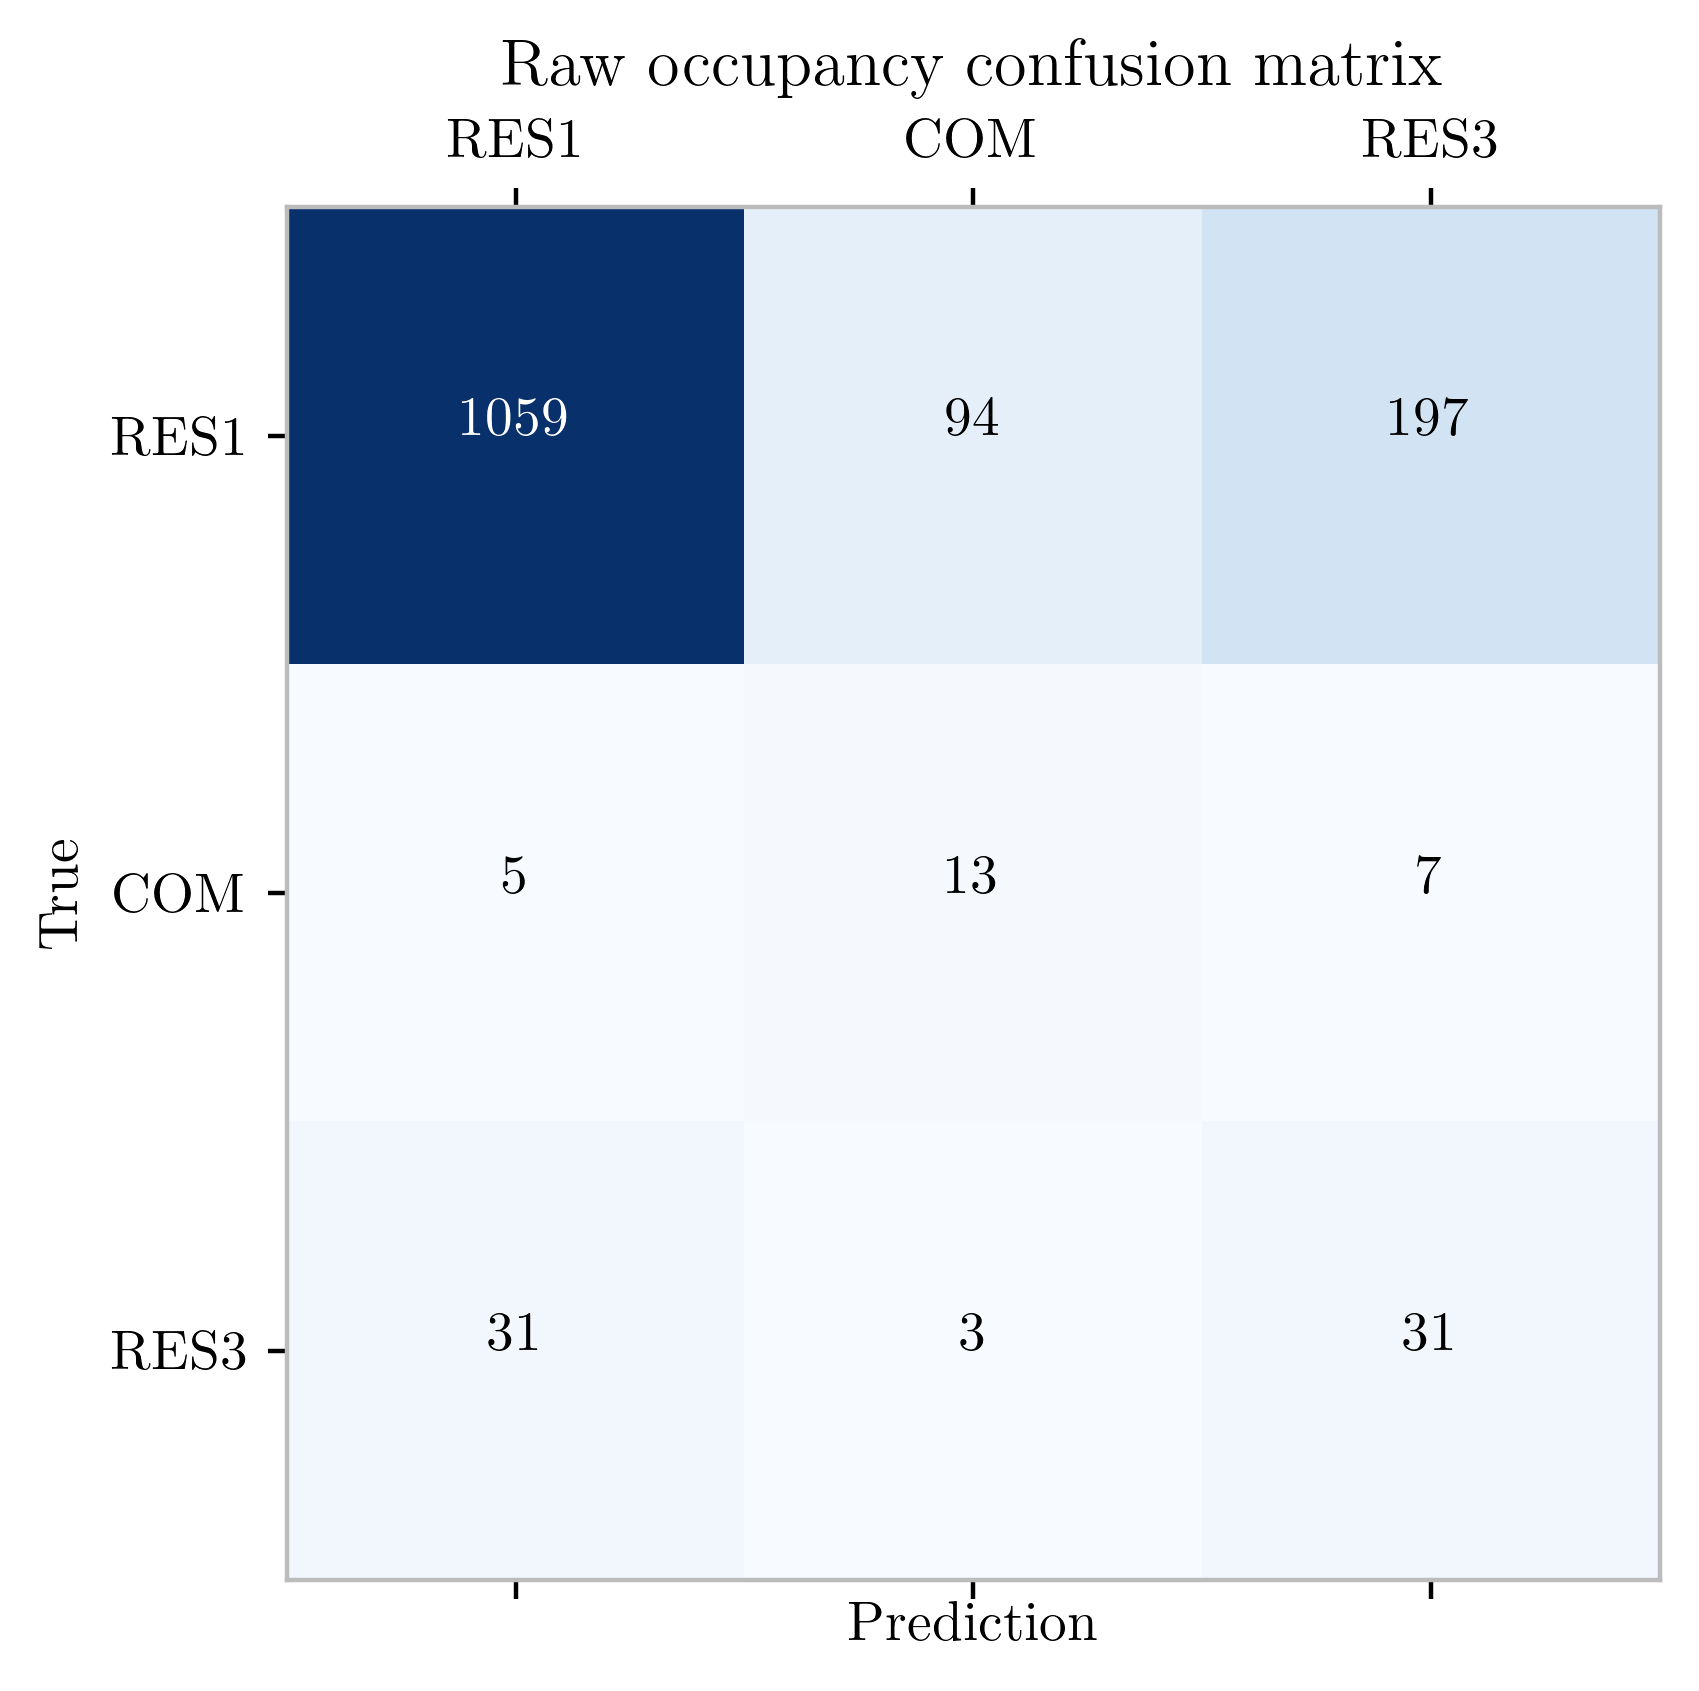

In [12]:
norms = ["true", "pred", "all"]
names = ["M[i,j] / sum(M[i,:])", "M[i,j] / sum(M[:,j])", "M[i,j] / sum(M)"]


cmatrix = sklearn.metrics.confusion_matrix(labels["label"], labels["prediction"], labels=label_keys)
ax_raw = plot_confusion_matrix(cmatrix,label_keys)
ax_raw.set_xticks(range(len(label_keys)))
ax_raw.set_xticklabels(label_keys)
ax_raw.set_yticks(range(len(label_keys)))
ax_raw.set_yticklabels(label_keys);
ax_raw.set_ylabel("True")
ax_raw.set_ylabel("True")
ax_raw.set_title(f"Raw {MODEL} confusion matrix")

if WRITE:
    ax_raw.figure.savefig(f"docs/{MODEL}-conf-raw.png")

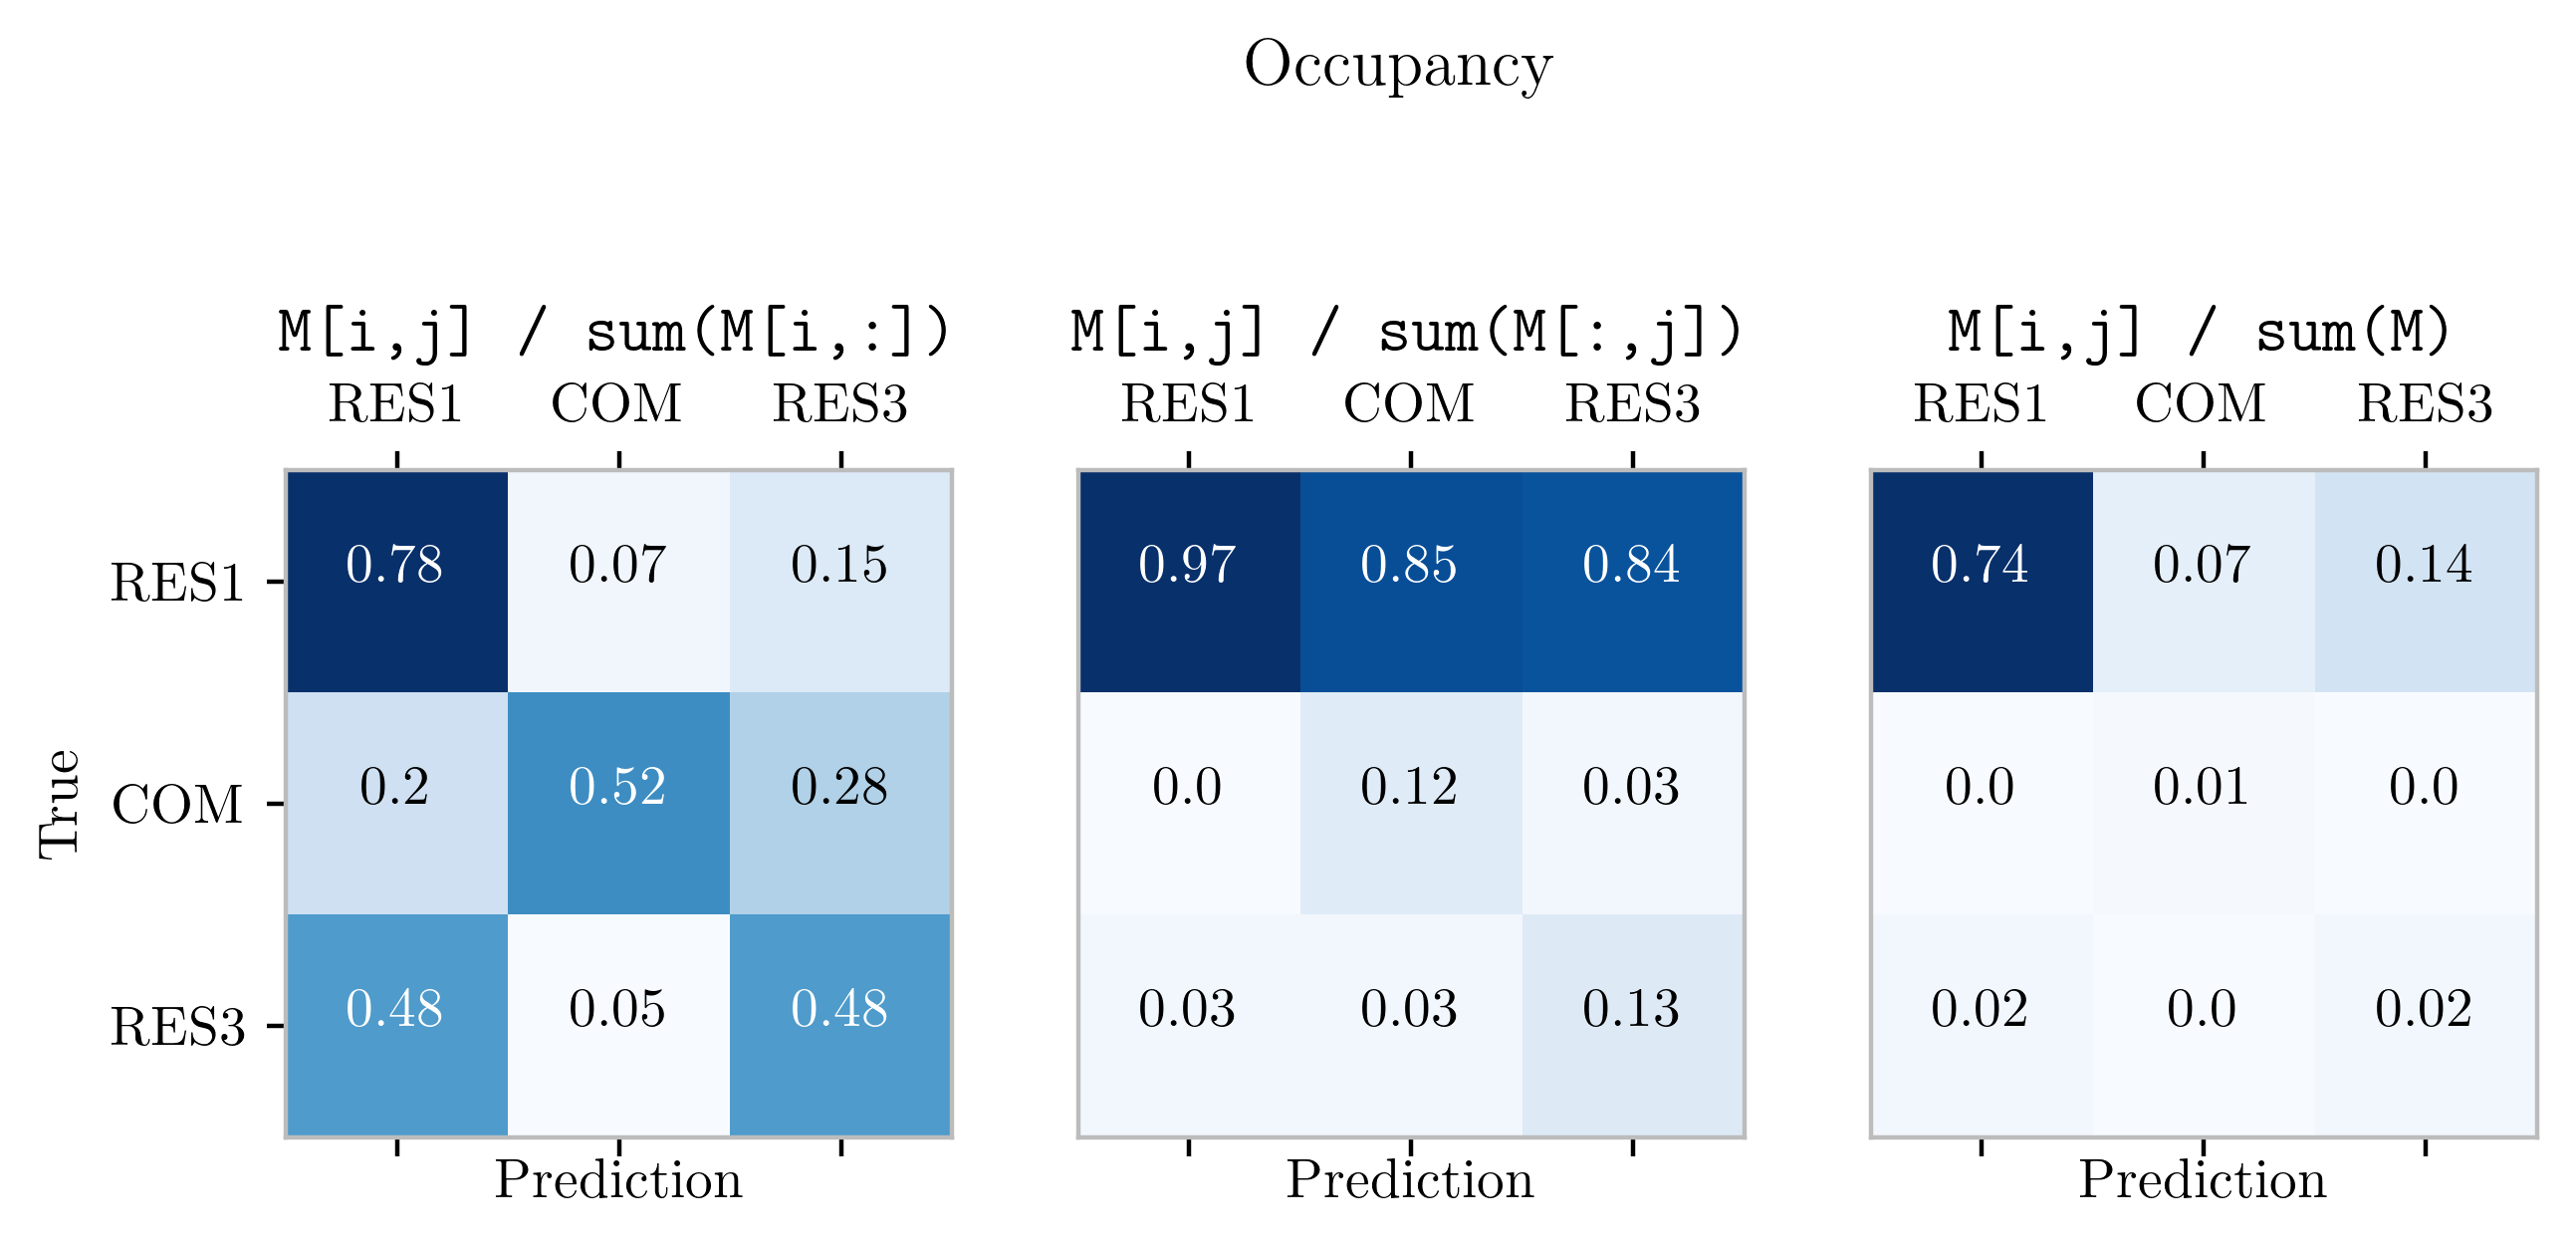

In [13]:
fig, ax = plt.subplots(1,len(norms))
for i,norm in enumerate(norms):
    cmatrix = sklearn.metrics.confusion_matrix(labels["label"], labels["prediction"], labels=label_keys, normalize=norm)
#     cmatrix = sklearn.metrics.confusion_matrix(labels["label"], labels["prediction"],normalize=norm)
    plot_confusion_matrix(cmatrix,label_keys, ax=ax[i],  title=f"\\texttt{{{names[i]}}}")
    ax[i].set_xticks(range(len(label_keys)))
    ax[i].set_xticklabels(label_keys)
    ax[i].get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].set_yticks(range(len(label_keys)))
ax[0].set_yticklabels(label_keys);
ax[0].set_ylabel("True")
fig.suptitle(f"{MODEL[0].upper() + MODEL[1:]}")

if WRITE:
    fig.savefig(f"docs/{MODEL}-conf.png")